In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as io
import scipy.signal as signal
import logging
import importlib
import os

# load and read nwb files
from pynwb import NWBHDF5IO

import ephys_extractor as efex
import ephys_features as ft
import ephys_utils

import plot_utils

from matplotlib.pyplot import imread
import matplotlib.image as mpimg
import matplotlib.patches as patches

## Ephys extraction

### Load data

Example cell:

In [5]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = NWBHDF5IO(
        "data/raw_data/sub-mouse-PAIFP_ses-20180529-sample-3_slice-20180529-slice-3_cell-20180529-sample-3_icephys.nwb",
        "r",
        load_namespaces=True,
    ).read()

In [6]:
from ephys_utils import get_time_voltage_current_currindex0

In [7]:
(
    time,
    voltage,
    current,
    curr_index_0,
) = get_time_voltage_current_currindex0(data)

In [8]:
print("time: ", time)
print("\n\ncurrent: ", current)
print("\n\nvoltage: ", voltage)
print("\n\ncurr_index_0: ", curr_index_0)

time:  [0.0000e+00 4.0000e-05 8.0000e-05 ... 8.9988e-01 8.9992e-01 8.9996e-01]


current:  [-200. -180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.
   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.  260.
  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.  500.
  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.  740.
  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.  980.
 1000. 1020. 1040. 1060. 1080. 1100. 1120. 1140. 1160. 1180. 1200. 1220.
 1240. 1260. 1280. 1300. 1320. 1340. 1360. 1380.]


voltage:  [[-75.37158579 -72.55011797 -72.7660954  ... -74.10480827 -73.62116128
  -73.43456149]
 [-75.35322011 -72.54234701 -72.72782922 ... -74.08511639 -73.6368522
  -73.42596352]
 [-75.33553988 -72.5369975  -72.6917237  ... -74.06820357 -73.65205139
  -73.4193325 ]
 ...
 [-72.20487297 -71.81895524 -71.42203301 ... -74.08417016 -74.13177192
  -73.76468927]
 [-72.18681276 -71.82814181 -71.40907645 ... -74.07046854

Pick current injections you'd want to visualize, and how big the lines should be.

In [9]:
current_inj1 = -200.0
current_inj2 = 60.0
current_inj3 = 480.0
lw = 4

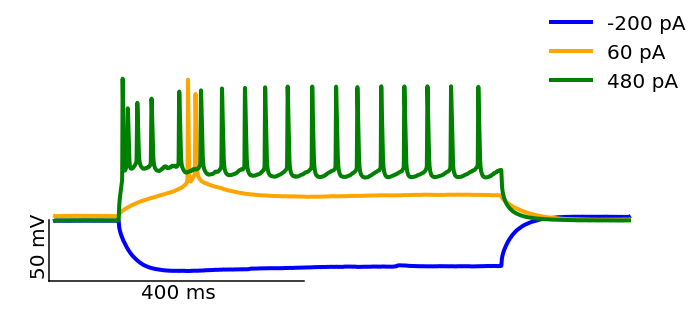

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(
    time * 1000,
    voltage[:, np.where(current == current_inj1)[0][0]],
    label="{} pA".format(int(current_inj1)),
    lw=lw,
    c="blue",
)
ax.plot(
    time * 1000,
    voltage[:, np.where(current == current_inj2)[0][0]],
    label="{} pA".format(int(current_inj2)),
    lw=lw,
    c="orange",
)
ax.plot(
    time * 1000,
    voltage[:, np.where(current == current_inj3)[0][0]],
    label="{} pA".format(int(current_inj3)),
    lw=lw,
    c="green",
)
ax.set_xlim([ax.get_xlim()[0] - 30, ax.get_xlim()[1] + 30])
ax.set_ylim([ax.get_ylim()[0] - 30, ax.get_ylim()[1] + 20])
ax.plot([-10, 390], [-125, -125], "k")
ax.annotate("400 ms", (135, -140), fontsize=20)
ax.plot([-10, -10], [-125, -75], "k")
ax.annotate("50 mV", (-40, -120), rotation="vertical", fontsize=20)
ax.legend(loc=(0.8, 0.8), frameon=False, fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True, bottom=True)
plt.savefig(
    "./figures/preliminary/traces.png", bbox_inches="tight", pad_inches=0, dpi=100
)

### Analyse action potentials

Extract electrophysiological features or summarizing statistics describing every action potential (AP) in each membrane voltage response to current injection.

In [11]:
from ephys_utils import extract_spike_features

In [12]:
df, df_related_features = extract_spike_features(time, current, voltage)

Here is some examples on how you can query certain things from these DataFrames

In [13]:
df.iloc[:7, :].loc[
    :,
    [
        "trough_t",
        "trough_v",
        "upstroke_t",
        "upstroke_v",
        "upstroke_downstroke_ratio",
        "width",
    ],
]

,trough_t,trough_v,upstroke_t,upstroke_v,upstroke_downstroke_ratio,width
0,0.21236,-42.765748,0.20804,0.124649,3.406355,0.00140
1,0.39836,-55.548076,0.21968,-5.234565,4.260611,0.00196
0,0.17184,-42.280011,0.16740,-5.397438,3.511935,0.00140
1,0.28376,-49.724415,0.17844,-4.987591,4.087442,0.00188
2,0.44260,-52.788947,0.37200,-4.515826,3.776890,0.00152
3,0.69996,-52.988686,0.60028,-1.244618,3.737638,0.00148
0,0.14948,-42.269621,0.14528,-3.078434,3.590461,0.00136


In [14]:
max_freq = np.max(df_related_features["spike_count"].values)
df_related_features.loc[
    df_related_features["spike_count"] == max_freq,
    [
        "fano_factor",
        "cv",
        "AP_fano_factor",
        "AP_cv",
        "current",
        "SFA",
        "avg_rate",
        "burstiness",
        "spike_count",
    ],
]

,fano_factor,cv,AP_fano_factor,AP_cv,current,SFA,avg_rate,burstiness,spike_count
0,0.001981,0.250817,1.059352,0.128923,500.0,0.727273,31.666667,0.555822,19
0,0.001890,0.244154,1.064476,0.130311,520.0,0.727273,31.666667,0.497512,19
0,0.003441,0.325390,1.241684,0.147337,560.0,0.727273,31.666667,0.473054,19
0,0.003656,0.336638,1.567656,0.174043,620.0,0.727273,31.666667,0.536921,19
0,0.005523,0.420047,2.174791,0.213000,660.0,0.583333,31.666667,0.509220,19


In [15]:
df_related_features.loc[
    df_related_features["current"] < 280, ["current", "input_resistance", "tau"]
]

,current,input_resistance,tau
0,-200.0,189.123623,0.020593
0,-180.0,204.069873,0.022260
0,-160.0,208.314141,0.021555
0,-140.0,209.064249,0.022389
0,-120.0,221.757136,0.023756
0,-100.0,222.123195,0.023751
0,-80.0,226.432956,0.025833
0,-60.0,236.994810,0.026828
0,-40.0,245.990020,0.029146
0,-20.0,261.475629,0.033888


Now we extract summarizing statistics of all membrane voltage trace responses to the different current injections.

In [16]:
from ephys_utils import get_cell_features

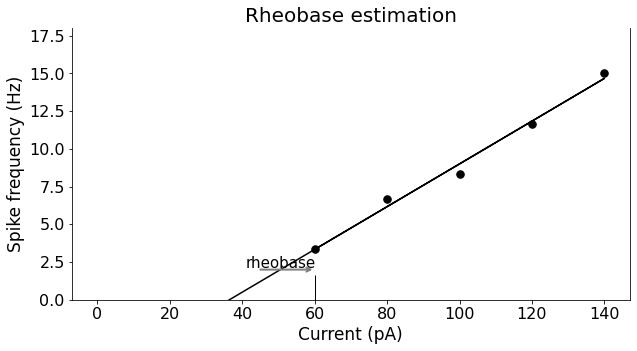

In [17]:
Cell_Features = get_cell_features(
    df, df_related_features, time, current, voltage, curr_index_0
)

Check our expert-defined electrophysiological feature or summarizing statistic values for this example cell.

In [18]:
Cell_Features[
    [
        "Resting membrane potential (mV)",
        "AP threshold (mV)",
        "AP width (ms)",
        "Afterhyperpolarization (mV)",
        "ISI coefficient of variation",
        "Sag ratio",
    ]
]

,Resting membrane potential (mV),AP threshold (mV),AP width (ms),Afterhyperpolarization (mV),ISI coefficient of variation,Sag ratio
0,-71.717137,-41.63209,1.4,-1.124404,0.250817,1.105408


### Plotting information as sanity check

In [20]:
from plot_utils import prel_inspection

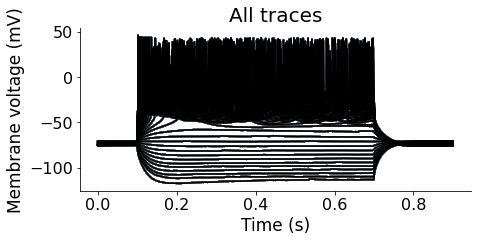

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
prel_inspection(data, axis=ax)
sns.despine()

In [22]:
from plot_utils import three_informative_traces

<Axes: title={'center': 'Three traces'}, xlabel='Time (s)', ylabel='Membrane voltage (mV)'>

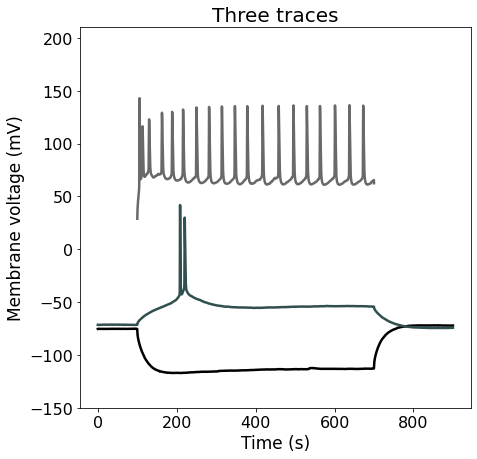

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
three_informative_traces(data, axis=ax)

In [24]:
from plot_utils import plot_info_first_peak

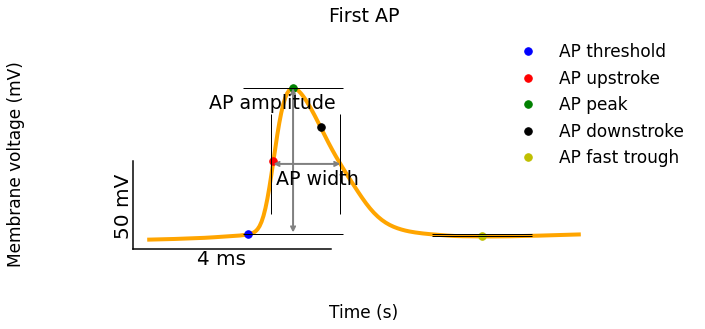

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax = plot_info_first_peak(data, axis=ax)
ax.set_xlim([ax.get_xlim()[0] - 2, ax.get_xlim()[1] + 2])
ax.set_ylim([ax.get_ylim()[0] - 30, ax.get_ylim()[1] + 30])
ax.plot([205.2, 209.2], [-50, -50], "k")
ax.annotate("4 ms", (206.5, -59), fontsize=20)
ax.plot([205.2, 205.2], [-50, 0], "k")
ax.annotate("50 mV", (204.8, -42), rotation="vertical", fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
sns.despine(ax=ax, left=True, bottom=True)
plt.savefig(
    "./figures/preliminary/1st_AP.png", bbox_inches="tight", pad_inches=0, dpi=100
)

In [26]:
from plot_utils import plot_max_spikes_trace

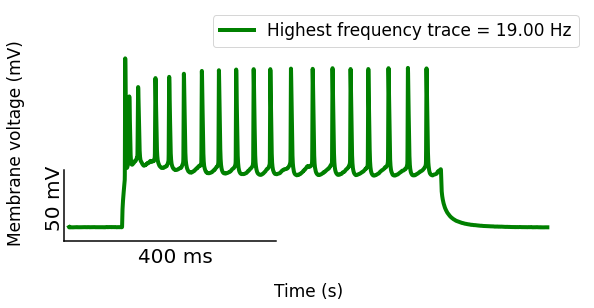

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_max_spikes_trace(data, axis=ax)
ax.set_xlim([ax.get_xlim()[0] - 30, ax.get_xlim()[1] + 30])
ax.set_ylim([ax.get_ylim()[0] - 30, ax.get_ylim()[1] + 30])
ax.plot([-10, 390], [-85, -85], "k")
ax.annotate("400 ms", (130, -100), fontsize=20)
ax.plot([-10, -10], [-85, -35], "k")
ax.annotate("50 mV", (-45, -75), rotation="vertical", fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
sns.despine(ax=ax, left=True, bottom=True)
plt.savefig(
    "./figures/preliminary/highest_firing_trace.png",
    bbox_inches="tight",
    pad_inches=0,
    dpi=100,
)

In [28]:
from plot_utils import plot_lowest_trace

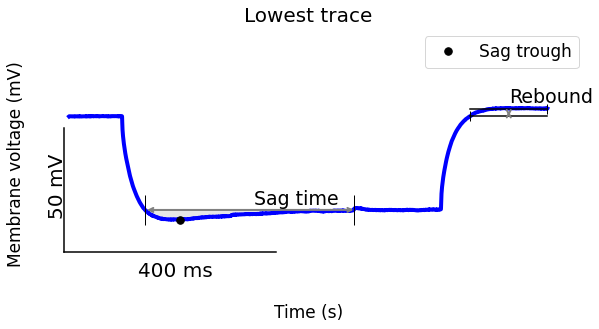

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_lowest_trace(data, axis=ax)
ax.set_xlim([ax.get_xlim()[0] - 30, ax.get_xlim()[1] + 30])
ax.set_ylim([ax.get_ylim()[0] - 30, ax.get_ylim()[1] + 30])
ax.plot([-10, 390], [-130, -130], "k")
ax.annotate("400 ms", (130, -140), fontsize=20)
ax.plot([-10, -10], [-130, -80], "k")
ax.annotate("50 mV", (-40, -115), rotation="vertical", fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
sns.despine(ax=ax, left=True, bottom=True)
plt.savefig(
    "./figures/preliminary/lowest_trace.png", bbox_inches="tight", pad_inches=0, dpi=100
)

In [31]:
def create_figure_1(fig):
    if fig is None:
        fig = plt.figure(figsize=(7, 18))
    else:
        fig = fig

    ax_exp = plt.axes([0, 0.8, 1, 0.2])
    ax_arrow = plt.axes([0.2, 0.6, 0.2, 0.2], zorder=3)
    ax_sketch = plt.axes([0.3, 0.65, 0.5, 0.1], zorder=4)
    ax_first_AP = plt.axes([0, 0.4, 1, 0.25], zorder=2)
    ax_max_fr = plt.axes([0, 0.2, 1, 0.25], zorder=1)
    ax_lowest_trace = plt.axes([0, 0, 1, 0.25], zorder=0)

    return ax_exp, ax_arrow, ax_sketch, ax_first_AP, ax_max_fr, ax_lowest_trace

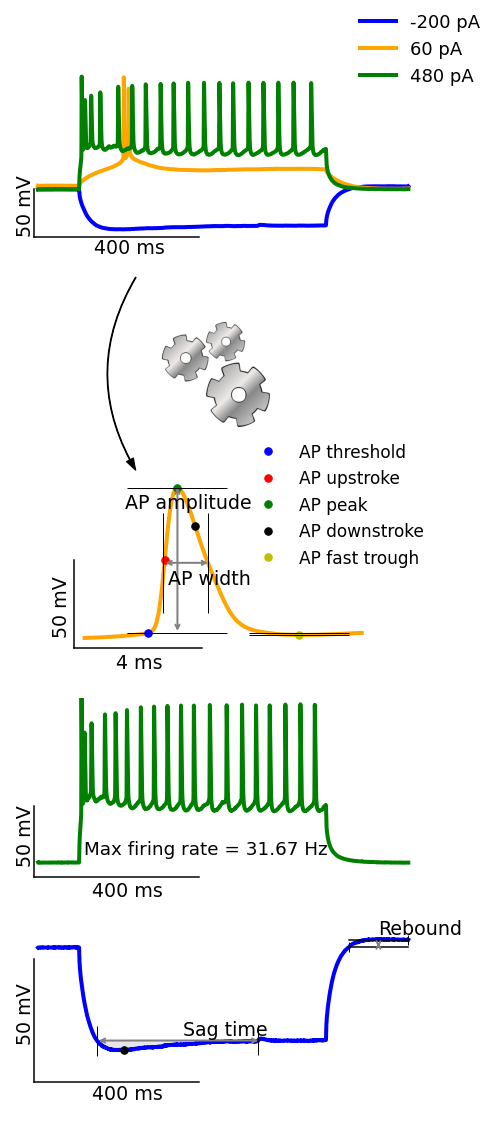

In [32]:
fig = plt.figure(figsize=(6, 15))
ax_exp, ax_arrow, ax_sketch, ax_first_AP, ax_max_fr, ax_lowest_trace = create_figure_1(
    fig
)

ax = ax_exp
ax.plot(
    time * 1000,
    voltage[:, np.where(current == current_inj1)[0][0]],
    label="{} pA".format(int(current_inj1)),
    lw=lw,
    c="blue",
)
ax.plot(
    time * 1000,
    voltage[:, np.where(current == current_inj2)[0][0]],
    label="{} pA".format(int(current_inj2)),
    lw=lw,
    c="orange",
)
ax.plot(
    time * 1000,
    voltage[:, np.where(current == current_inj3)[0][0]],
    label="{} pA".format(int(current_inj3)),
    lw=lw,
    c="green",
)
ax.set_xlim([ax.get_xlim()[0] - 30, ax.get_xlim()[1] + 30])
ax.set_ylim([ax.get_ylim()[0] - 30, ax.get_ylim()[1] + 20])
ax.plot([-10, 390], [-125, -125], "k")
ax.annotate("400 ms", (135, -142), fontsize=19)
ax.plot([-10, -10], [-125, -75], "k")
ax.annotate("50 mV", (-53, -120), rotation="vertical", fontsize=19)
ax.legend(loc=(0.8, 0.8), frameon=False, fontsize=18)

ax = ax_sketch
img = imread("figures/preliminary/tooth_wheel_sketch.png")
ax.imshow(img)

style = "Simple, tail_width=0.8, head_width=8, head_length=12"
kw = dict(arrowstyle=style, color="k")

ax_arrow.set_xlim([-0.05, 1.05])
ax_arrow.set_ylim([-0.05, 1.05])
arrow = patches.FancyArrowPatch((0.5, 1), (0.5, 0), connectionstyle="arc3,rad=.3", **kw)
ax_arrow.add_patch(arrow)
# ax_arrow.arrow(0.1, 0.9, 0, -0.8, width=0.1, color="k")

ax = ax_first_AP
ax = plot_info_first_peak(data, axis=ax)
ax.set_xlim([ax.get_xlim()[0] - 2, ax.get_xlim()[1] + 2])
ax.set_ylim([ax.get_ylim()[0] - 30, ax.get_ylim()[1] + 30])
ax.plot([205.2, 209.2], [-50, -50], "k")
ax.annotate("4 ms", (206.5, -62), fontsize=19)
ax.plot([205.2, 205.2], [-50, 0], "k")
ax.annotate("50 mV", (204.5, -42), rotation="vertical", fontsize=19)

ax = ax_max_fr
ax = plot_max_spikes_trace(data, axis=ax)
ax.set_xlim([ax.get_xlim()[0] - 30, ax.get_xlim()[1] + 30])
ax.set_ylim([ax.get_ylim()[0] - 30, ax.get_ylim()[1] + 30])
ax.plot([-10, 390], [-85, -85], "k")
ax.annotate("400 ms", (130, -99), fontsize=19)
ax.plot([-10, -10], [-85, -35], "k")
ax.annotate("50 mV", (-54, -75), rotation="vertical", fontsize=19)
ax.annotate(
    "Max firing rate = {:.2f} Hz".format(
        Cell_Features["Max number of APs"].values[0] / 0.6
    ),
    (111, -69),
    fontsize=18.35,
)


ax = ax_lowest_trace
ax = plot_lowest_trace(data, axis=ax)
ax.set_xlim([ax.get_xlim()[0] - 30, ax.get_xlim()[1] + 30])
ax.set_ylim([ax.get_ylim()[0] - 30, ax.get_ylim()[1] + 30])
ax.plot([-10, 390], [-130, -130], "k")
ax.annotate("400 ms", (130, -137), fontsize=19)
ax.plot([-10, -10], [-130, -80], "k")
ax.annotate("50 mV", (-53, -113), rotation="vertical", fontsize=19)

for ax in [ax_exp, ax_arrow, ax_sketch, ax_first_AP, ax_max_fr, ax_lowest_trace]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    sns.despine(ax=ax, left=True, bottom=True)
plt.savefig("figures/ephys_extraction.pdf", bbox_inches="tight", pad_inches=0)